In [1]:
# import libraries
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

#
from torch.utils.data import DataLoader

In [2]:
# import dataset
import pandas as pd
iris = pd.read_csv('https://raw.githubusercontent.com/mwaskom/seaborn-data/master/iris.csv')

In [3]:
# organize the data

# convert from pandas dataframe to tensor
data = torch.tensor( iris[iris.columns[0:4]].values ).float()

# transform species to number
labels = torch.zeros(len(data), dtype=torch.long)
# labels[iris.species=='setosa']   = 0 # don't need!
labels[iris.species=='versicolor'] = 1
labels[iris.species=='virginica']  = 2

### Batch the Data

In [4]:
# use scikitlearn to split the data
train_data,test_data, train_labels,test_labels = train_test_split(data, labels, test_size=.2)

# then convert them into PyTorch Datasets (note: already converted to tensors)
train_dataDataset = torch.utils.data.TensorDataset(train_data,train_labels)
test_dataDataset  = torch.utils.data.TensorDataset(test_data,test_labels)

# create dataloader objects
train_loader = DataLoader(train_dataDataset,batch_size=64, shuffle=True, drop_last=True)
test_loader  = DataLoader(test_dataDataset,batch_size=test_dataDataset.tensors[0].shape[0])

### Create Model

In [5]:
model = nn.Sequential(
    nn.Linear(4, 64),
    nn.ReLU(),
    nn.Linear(64, 64),
    nn.ReLU(),
    nn.Linear(64, 3),
)

lossfun = nn.CrossEntropyLoss()

# Applying L2 regularization
l2lambda = 0.01
optimizer = torch.optim.Adam(model.parameters(), lr=0.01,weight_decay=l2lambda)

In [6]:
num_epochs = 1000

train_acc = []
test_acc = []
losses = []

for epoch in range(num_epochs):
    batchAcc = []
    batchLoss = []

    for x,y in train_loader:
        yhat = model(x)

        loss = lossfun(yhat, y)

        # Applying L1 regularization
        l1_term = torch.tensor(0.0,requires_grad=True)
        n_weights = 0
        for pname,weight in model.named_parameters():
            if 'bias' not in pname:
                l1_term = l1_term + torch.sum(torch.abs(weight))
                n_weights += 1
        loss = loss + 0.01 * l1_term / n_weights

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        batchAcc.append( (yhat.argmax(1) == y).float().mean().item() )
        batchLoss.append(loss.item())
    train_acc.append(np.mean(batchAcc))
    losses.append(np.mean(batchLoss))

    # test the model 
    model.eval()
    X,y = next(iter(test_loader))
    yhat = model(X)
    test_acc.append(100*torch.mean((torch.argmax(yhat,axis=1) == y).float()).item())

    model.train()

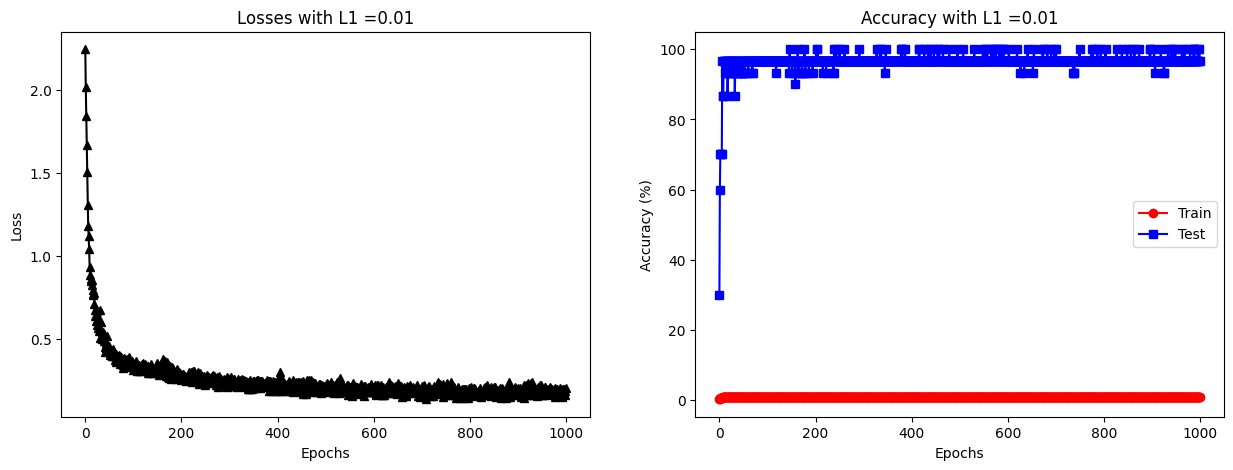

In [7]:
# plot the results
fig,ax = plt.subplots(1,2,figsize=(15,5))


ax[0].plot(losses,'k^-')
ax[0].set_ylabel('Loss')
ax[0].set_xlabel('Epochs')
ax[0].set_title('Losses with L1 =' + str(0.01))

ax[1].plot(train_acc,'ro-')
ax[1].plot(test_acc,'bs-')
ax[1].set_title('Accuracy with L1 =' + str(0.01))
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy (%)')
ax[1].legend(['Train','Test'])

plt.show()